In [1]:
%pip install scikit-learn scikit-lego

                                              0.0/229.1 kB ? eta -:--:--
     -------------------------------------- 229.1/229.1 kB 7.1 MB/s eta 0:00:00
                                              0.0/49.3 kB ? eta -:--:--
     ---------------------------------------- 49.3/49.3 kB 2.6 MB/s eta 0:00:00
                                              0.0/90.8 kB ? eta -:--:--
     ---------------------------------------- 90.8/90.8 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
                                              0.0/1.1 MB ? eta -:--:--
     ---                                      0.1/1.1 MB 6.4 MB/s eta 0:00:01
     -----------                              0.3/1.1 MB 3.9 MB/s eta 0:00:01
     ----------------------                   0.6/1.1 MB 5.1 MB/s eta 0:00:01
     ----------------------------------       1.0/1.1 MB 6.3 MB/s eta 0:00:01
     ---------------------------------------- 1.1/1.1 MB 6

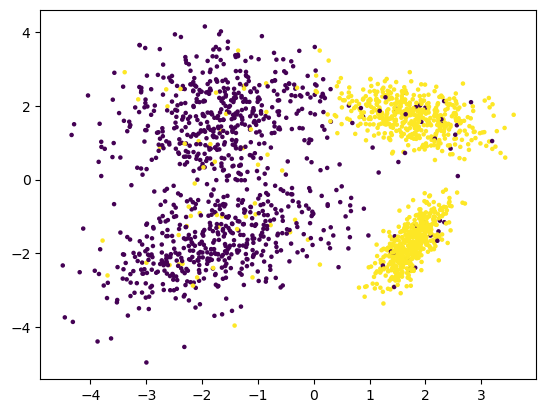

In [2]:
import numpy as np
import matplotlib.pylab as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.datasets import make_classification

X, y = make_classification(n_samples=2000, n_features=2,
                           n_redundant=0, random_state=21,
                           class_sep=1.75, flip_y=0.1)
plt.scatter(X[:, 0], X[:, 1], c=y, s=5);

In [3]:
def make_plots():
    X_new = np.concatenate([
        np.random.uniform(np.min(X[:, 0]), np.max(X[:, 0]), (20000, 1)),
        np.random.uniform(np.min(X[:, 1]), np.max(X[:, 1]), (20000, 1))
    ], axis=1)
    plt.figure(figsize=(16, 4))
    plt.subplot(141)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=5)
    plt.title("original data")
    plt.subplot(142)
    plt.scatter(X_new[:, 0], X_new[:, 1], c=clf1.predict_proba(X_new)[:, 1], s=5)
    plt.title("ens1")
    plt.subplot(143)
    plt.scatter(X_new[:, 0], X_new[:, 1], c=clf2.predict_proba(X_new)[:, 1], s=5)
    plt.title("ens2")
    plt.subplot(144)
    plt.scatter(X_new[:, 0], X_new[:, 1], c=clf3.predict_proba(X_new)[:, 1], s=5)
    plt.title("ens3");

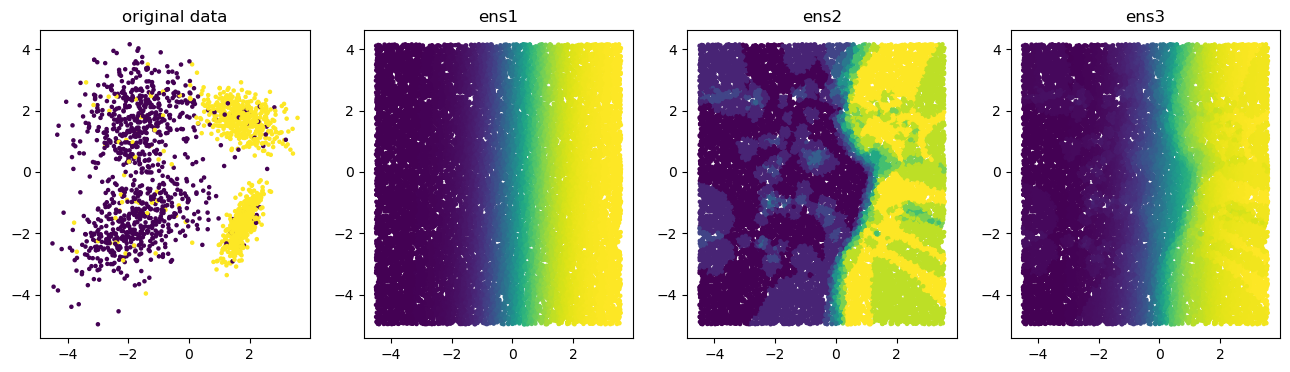

In [4]:
clf1 = LogisticRegression().fit(X, y)
clf2 = KNeighborsClassifier(n_neighbors=10).fit(X, y)
clf3 = VotingClassifier(estimators=[('clf1', clf1), ('clf2', clf2)],
                        voting='soft',
                        weights=[10.5, 2.5])
clf3.fit(X, y)

make_plots()

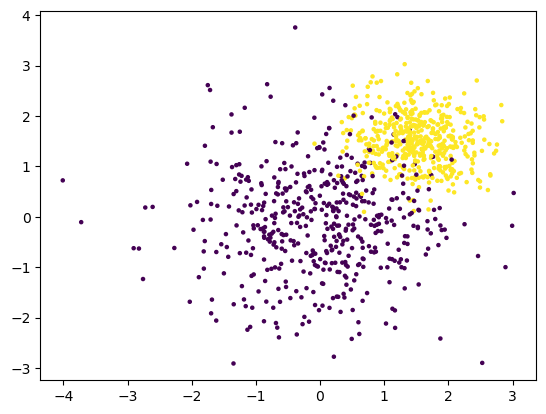

In [5]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.datasets import make_blobs
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import precision_score, recall_score, accuracy_score, make_scorer

from sklego.meta import Thresholder

X, y = make_blobs(1000, centers=[(0, 0), (1.5, 1.5)], cluster_std=[1, 0.5])
plt.scatter(X[:, 0], X[:, 1], c=y, s=5);

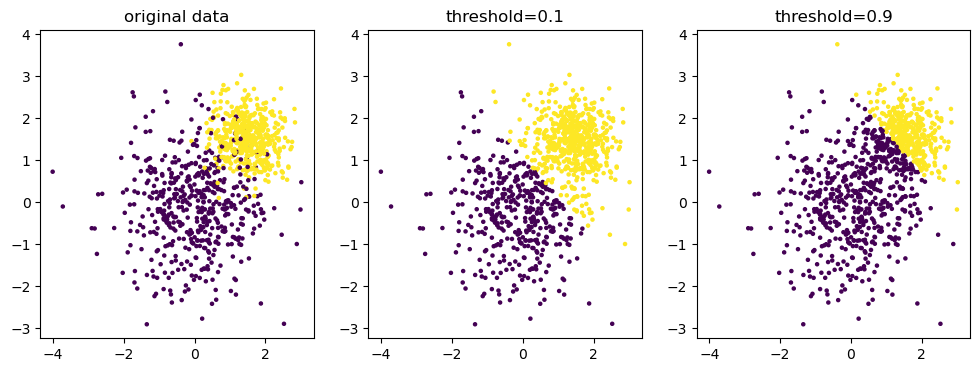

In [6]:
m1 = Thresholder(LogisticRegression(solver='lbfgs'), threshold=0.1).fit(X, y)
m2 = Thresholder(LogisticRegression(solver='lbfgs'), threshold=0.9).fit(X, y)

plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.scatter(X[:, 0], X[:, 1], c=y, s=5)
plt.title("original data")
plt.subplot(132)
plt.scatter(X[:, 0], X[:, 1], c=m1.predict(X), s=5)
plt.title("threshold=0.1")
plt.subplot(133)
plt.scatter(X[:, 0], X[:, 1], c=m2.predict(X), s=5)
plt.title("threshold=0.9");

In [7]:
pipe = Pipeline([
    ("model", Thresholder(LogisticRegression(solver='lbfgs'), threshold=0.1))
])

mod = GridSearchCV(estimator=pipe,
                  param_grid = {"model__threshold": np.linspace(0.1, 0.9, 50)},
                  scoring={"precision": make_scorer(precision_score),
                            "recall": make_scorer(recall_score),
                            "accuracy": make_scorer(accuracy_score)},
                  refit="precision",
                  cv=5)

mod.fit(X, y);